
 <font size="6">
 <div class="alert alert-block alert-info"> <b>APVC - Redes neuronais convolucionais - Exemplo<b>
     </div>
</font>

__________________
  <font size="4"> Tomás Brandão</font>

  <font size="3"> *tomas.brandao@iscte-iul.pt* </font>

  <font size="3"> Março de 2025 </font>
 _________________

## Classificação de imagens de flores

Este notebook encontra-se segundo seis partes:
1. Importação das bibliotecas necessárias
2. Carregamento dos datasets
3. Definição de callbacks
4. Definição e compilação do modelo
5. Treino do modelo
6. Resultados

In [1]:
import keras
from keras import layers
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

## Carregamento dos datasets
Neste exemplo assume-se que o dataset `flower_photos`, disponibilizado no Moodle, foi descomprimido para o diretório `../datasets/flower_photos`. Assume-se também que o dataset é composto por vários sub-diretórios, cada um contendo as imagens de cada uma das classes (neste caso são cinco espécies diferentes de flores, pelo que temos 5 classes e, consequentemente, 5 sub-diretórios no dataset).

A função `keras.utils.image_dataset_from_directory(...)` permite carregar para a memória um dataset que se encontre no sistema de ficheiros.  

In [2]:
# Constantes
BATCH_SIZE = 64
IMG_HEIGHT = 160
IMG_WIDTH = 160

DATASET_PATH = "../datasets/flower_photos"  # ajustar consoante a localização do dataset
SEED = 1245                                 # semente para o split treino/validação
TRAIN_VAL_SPLIT = 0.2                       # fração de imagens para validação
NUM_CLASSES = 5                             # número de classes

# Neste exemplo o dataset é carregado a partir do sistema de ficheiros
# e apenas é dividido em treino e validação - não se definiu um conjunto de teste

train_ds, val_ds = keras.utils.image_dataset_from_directory(
  DATASET_PATH,
  labels='inferred',
  label_mode='categorical',
  validation_split=TRAIN_VAL_SPLIT,
  subset="both",
  seed=SEED,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  batch_size=BATCH_SIZE)

# as labels foram inferidas a partir dos nomes dos diretórios
labels = train_ds.class_names
print("Encontradas as classes: ",labels)

# carregar os datasets em memória - uma vez carregados, a ordem dos batches já não muda
train_ds = train_ds.cache()
val_ds = val_ds.cache()

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Using 734 files for validation.
Encontradas as classes:  ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


## Definição dos callbacks
Foram definidos dois <i>callbacks</i>:

- `BEST_MODEL_CHECKPOINT` - para ir guardando o melhor modelo (por "melhor" entenda-se o que tem menor <i>loss</i>)
- `EARLY_STOPPING`- para terminar o treino quando não há melhorias na loss da validação durante <i>n</i> épocas consecutivas (<i>n</i> é definido pelo parâmetro `patience`, neste caso definiu-se 5)

In [3]:
# ficheiro onde serão guardados os pesos do "melhor modelo" - ajustar o caminho
BEST_MODEL_PATH = "tmp/best_model.weights.h5"

# callback para guardar o melhor modelo
BEST_MODEL_CHECKPOINT = keras.callbacks.ModelCheckpoint(
    filepath=BEST_MODEL_PATH,
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

# callback para parar o treino caso não se verifiquem melhorias na loss
EARLY_STOPPING = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5)

## Definição e compilação do modelo
O modelo definido é uma rede neuronal convolucional (CNN), muito simples, com camadas convolucionais intercaladas com camadas de pooling. Note-se que o modelo não está otimizado e pretende ser apenas um exemplo.

In [4]:
# arquitetura da CNN
flower_model = keras.Sequential([
    layers.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    layers.Conv2D(16, 5, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=4),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(NUM_CLASSES, activation="softmax")
])

# definição do algoritmo de otimização e da função de perda (loss)
flower_model.compile(optimizer='adam',
                     loss="categorical_crossentropy",
                     metrics=['accuracy'])

# sumário do modelo
flower_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 160, 160, 16)   │         1,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 80, 80, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 80, 80, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 40, 40, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 40, 40, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 508,581 (1.94 MB)

 Trainable params: 508,581 (1.94 MB)

 Non-trainable params: 0 (0.00 B)

## Treino do modelo
Treinar com a função `fit(...)`. Em relação ao que já foi visto anteriormente, destaca-se o facto de agora não se especificar o batch_size, pois o `train_ds` já se encontra dividido em batches (a função `keras.utils.image_dataset_from_directory(...)` tratou disso).

In [5]:
EPOCHS = 30
history = flower_model.fit(train_ds,
                    epochs=EPOCHS,
                    validation_data=val_ds,
                    callbacks=[EARLY_STOPPING, BEST_MODEL_CHECKPOINT])

Epoch 1/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - accuracy: 0.2275 - loss: 18.7825 - val_accuracy: 0.3842 - val_loss: 1.4601
Epoch 2/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - accuracy: 0.4100 - loss: 1.3905 - val_accuracy: 0.4728 - val_loss: 1.2791
Epoch 3/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.4896 - loss: 1.2100 - val_accuracy: 0.5014 - val_loss: 1.2256
Epoch 4/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.5752 - loss: 1.0782 - val_accuracy: 0.6444 - val_loss: 0.9742
Epoch 5/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step - accuracy: 0.6239 - loss: 0.9361 - val_accuracy: 0.6131 - val_loss: 1.0417
Epoch 6/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.6466 - loss: 0.8920 - val_accuracy: 0.6471 - val_loss: 0.9499
Epoch 7/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.7055 - loss: 0.7588 - val_accuracy: 0.6635 - val_loss: 0.9286
Epoch 8/30
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 75ms/step - accuracy: 0.7484 - loss: 0.6773 - val_accuracy: 0.6540 - 

## Mostrar resultados

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Falhou em 247 amostras num total de 734 imagens de flores
Taxa de acertos: 66.35 %


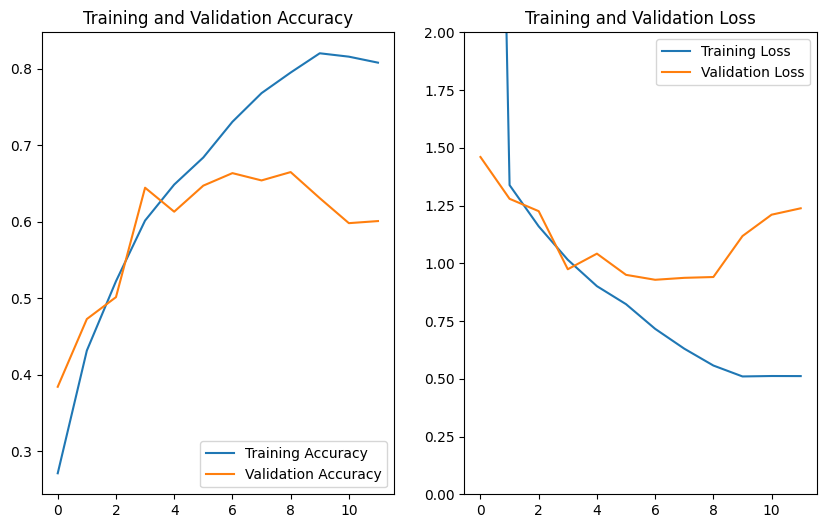

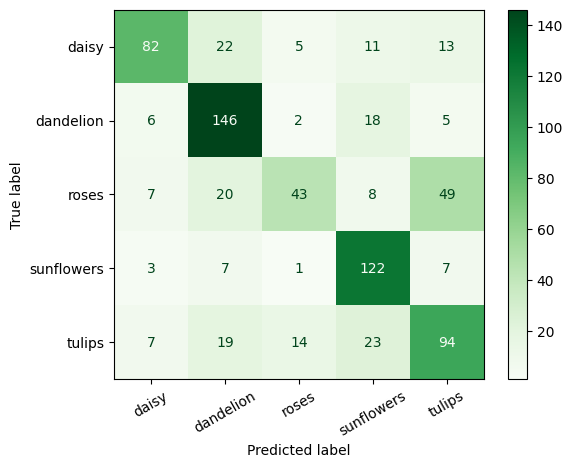

In [6]:
# carregar o melhor modelo encontrado durante o treino
flower_model.load_weights(BEST_MODEL_PATH)

# obter as predições e ground thruth num formato mais fácil de tratar
# (vetores com os ids das classes)

# realizar as predições
y_pred = flower_model.predict(val_ds)
pred_ids = np.argmax(y_pred, axis=1)

# concatena os "targets" do conjunto de validação (pois estavam organizados em batches)
y_true = np.concat([y for x, y in val_ds], axis=0)
true_ids = np.argmax(y_true, axis=1)

n_misses = np.count_nonzero(pred_ids != true_ids)
n_preds = pred_ids.shape[0]
accuracy = (n_preds - n_misses) / n_preds

print("Falhou em {:d} amostras num total de {:d} imagens de flores".format(n_misses, n_preds))
print("Taxa de acertos: {:.2f} %".format(accuracy * 100))


# gerar gráficos e matriz de confusão
cm = confusion_matrix(true_ids, pred_ids)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

# evolucao da loss e acertos
plt.figure(2, figsize=(10, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylim(0, 2)
plt.title('Training and Validation Loss')

# matriz de confusao
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot(cmap='Greens', xticks_rotation=30)
plt.show()